# 📈 RSI Trading Strategy Backtest (SPY)

This notebook implements a simple RSI (Relative Strength Index) based trading strategy on SPY (S&P 500 ETF) using Python.

We'll backtest the strategy, evaluate its risk-adjusted performance, and visualize trading signals.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_ta as ta
import numpy as np

sns.set(style="whitegrid")

In [ ]:
# Download SPY data from Yahoo Finance and ensure proper output
df = yf.download("SPY", start="2015-01-01", end="2025-01-01", auto_adjust=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df.columns.name = None 
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,172.075272,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,168.967590,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,167.376144,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,169.461807,202.309998,202.720001,200.880005,201.419998,125346700
2015-01-08,172.468918,205.899994,206.160004,203.990005,204.009995,147217800


In [5]:
# Add 14-period RSI to the dataframe
df["RSI"] = ta.rsi(df["Adj Close"], length=14)
df.tail()

,Adj Close,Close,High,Low,Open,Volume,RSI
Date,,,,,,,
2024-12-24,599.496582,601.299988,601.340027,595.469971,596.059998,33160100,56.013038
2024-12-26,599.536499,601.340027,602.479980,598.080017,599.500000,41219100,56.048283
2024-12-27,593.225464,595.010010,597.780029,590.760010,597.539978,64969300,49.319625
2024-12-30,586.455811,588.219971,591.739990,584.409973,587.890015,56578800,43.312947
2024-12-31,584.322266,586.080017,590.640015,584.419983,589.909973,57052700,41.593609


In [6]:
# Generate trading signals based on RSI
df["Signal"] = 0
df.loc[df["RSI"] < 30, "Signal"] = 1  # Buy
df.loc[df["RSI"] > 70, "Signal"] = -1  # Sell

df[["Adj Close", "RSI", "Signal"]].tail()

,Adj Close,RSI,Signal
Date,,,
2024-12-24,599.496582,56.013038,0
2024-12-26,599.536499,56.048283,0
2024-12-27,593.225464,49.319625,0
2024-12-30,586.455811,43.312947,0
2024-12-31,584.322266,41.593609,0


In [7]:
# Simulate portfolio value
initial_cash = 10000
cash = initial_cash
position = 0
portfolio = []

for i in range(1, len(df)):
    price = df["Adj Close"].iloc[i]
    signal = df["Signal"].iloc[i]

    if signal == 1 and position == 0:
        position = cash / price
        cash = 0
    elif signal == -1 and position > 0:
        cash = position * price
        position = 0

    total_value = cash + position * price
    portfolio.append(total_value)

# Add portfolio value to the dataframe
df = df.iloc[1:].copy()
df["Portfolio"] = portfolio

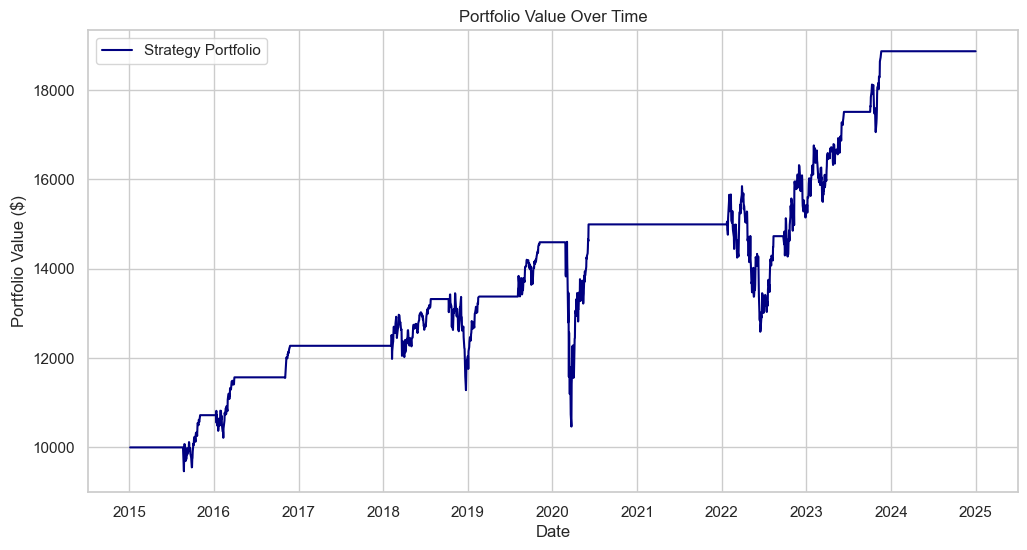

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Portfolio"], label="Strategy Portfolio", color="navy")
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()

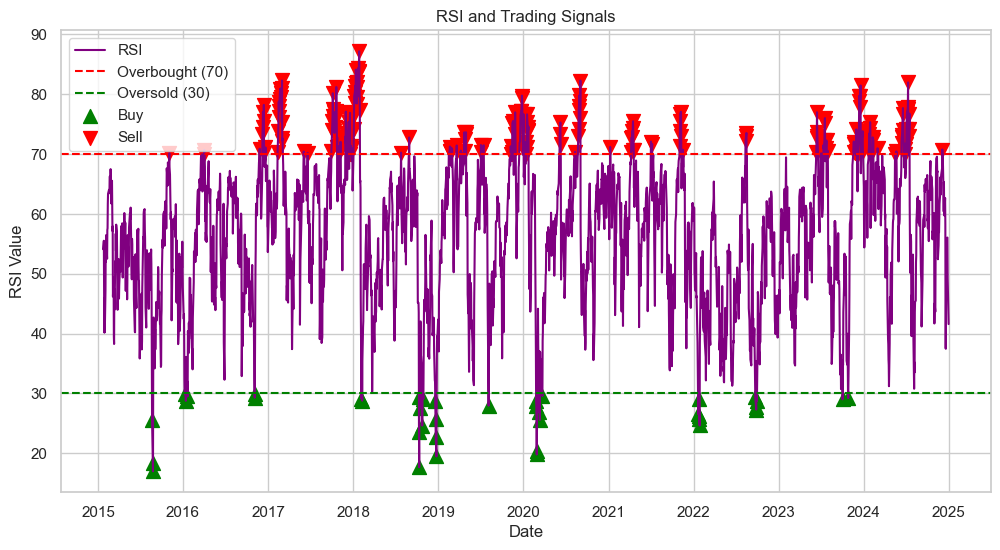

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["RSI"], label="RSI", color="purple")
plt.axhline(70, color="red", linestyle="--", label="Overbought (70)")
plt.axhline(30, color="green", linestyle="--", label="Oversold (30)")

buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]
plt.scatter(buy_signals.index, buy_signals["RSI"], color="green", marker="^", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["RSI"], color="red", marker="v", label="Sell", s=100)

plt.title("RSI and Trading Signals")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.show()

In [10]:
# Helper functions
def calculate_cagr(df):
    start = df["Portfolio"].iloc[0]
    end = df["Portfolio"].iloc[-1]
    num_years = (df.index[-1] - df.index[0]).days / 365.25
    return (end / start) ** (1/num_years) - 1

def calculate_volatility(df):
    daily_returns = df["Portfolio"].pct_change().dropna()
    return daily_returns.std() * np.sqrt(252)

def calculate_sharpe(df):
    daily_returns = df["Portfolio"].pct_change().dropna()
    return (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

def calculate_max_drawdown(df):
    cummax = df["Portfolio"].cummax()
    drawdown = df["Portfolio"] / cummax - 1
    return drawdown.min()

# Calculate metrics
cagr = calculate_cagr(df)
volatility = calculate_volatility(df)
sharpe = calculate_sharpe(df)
mdd = calculate_max_drawdown(df)

print(f"CAGR: {cagr:.2%}")
print(f"Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")

CAGR: 6.56%
Volatility: 14.23%
Sharpe Ratio: 0.52
Max Drawdown: -28.32%


## 📈 Conclusion

The RSI-based trading strategy on SPY generated a CAGR of 6.56%, with a Sharpe Ratio of 0.52 and a maximum drawdown of 28.32%.

While the strategy can identify short-term reversals, improvements such as optimized parameters or multi-indicator filters could further enhance performance.
